## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

![mesh](data/mesh.png)

The domain is partioned in nine square subdomains.

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            theta_a2 = mu[1]
            theta_a3 = 1.
            theta_a4 = 1.
            theta_a5 = 1.
            theta_a6 = mu[2]
            theta_a7 = 1.
            theta_a8 = mu[3]
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = 1.
            theta_f1 = mu[4]
            theta_f2 = 1.
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

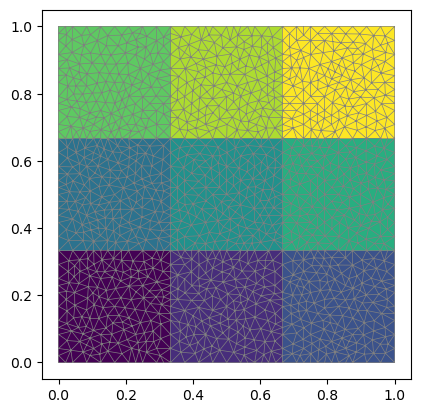

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 0.5
plot(subdomains)
plot(mesh)
plt.savefig("data/mesh.png", bbox_inches='tight')

### 4.2. Create Finite Element space (Lagrange P1)

In [5]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [6]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [7]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [8]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=                ElasticBlock POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (55.33253688880515, 71.80374727086952, 60.67357423109274, 54.94343511669279, -0.15269040132219058)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (64.94351719359895, 44.321133915006556, 89.2855270774259, 96.4026132896019, -0.2331169623484446)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (79.3807787701838, 53.360597055537546, 57.2364115482993, 92.63406719097344, -0.8579278836042261)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (9.62580067045253, 3.001621346592246, 83.42936470924586, 78.03751834403519, 0.7400242964936383)
update snapshots matrix

#####################

truth solve for mu = (23.168544117977632, 35.189816388993364, 92.8800480530935, 70.73702579042974, -0.9363221409373843)
update snapshots matrix

###################################### 36 ######################################
truth solve for mu = (17.30472149329336, 62.52636174847659, 58.14563027181259, 24.551389316076353, 0.8684279958495875)
update snapshots matrix

###################################### 37 ######################################
truth solve for mu = (61.7826296406237, 54.02764749947087, 59.40108765910253, 73.28208092216019, -0.3761100090407963)
update snapshots matrix

###################################### 38 ######################################
truth solve for mu = (40.423885159393095, 21.774531148537093, 19.43310758215328, 94.49286660840943, 0.4791015900985751)
update snapshots matrix

###################################### 39 ######################################
truth solve for mu = (49.55542205313914, 23.514048169359, 26.1812916952689, 6.744886872063686, -0.1

update snapshots matrix

###################################### 72 ######################################
truth solve for mu = (19.52595828333363, 90.49441153789546, 54.83678905765531, 46.23423074293081, 0.7640828204597792)
update snapshots matrix

###################################### 73 ######################################
truth solve for mu = (46.40179221509, 72.69259602454278, 40.503506848607095, 90.50039489719481, 0.3800500403824547)
update snapshots matrix

###################################### 74 ######################################
truth solve for mu = (70.26258337080115, 33.44431975415477, 75.92108563095204, 63.97004448926699, -0.5199594532405809)
update snapshots matrix

###################################### 75 ######################################
truth solve for mu = (16.893343426040385, 79.84275597721584, 95.95749370048702, 46.355743898744244, 0.18196833064736984)
update snapshots matrix

###################################### 76 ###################################

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [9]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [10]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 12.33834653796367 	Loss(validation) = 10.27632921645275
100 	Loss(training) = 0.06460782005888517 	Loss(validation) = 0.09077323166227166
200 	Loss(training) = 0.04574765738443925 	Loss(validation) = 0.06697487814704539
300 	Loss(training) = 0.03827535232284977 	Loss(validation) = 0.05622110426585998
400 	Loss(training) = 0.03299669524604996 	Loss(validation) = 0.048513910646448485
500 	Loss(training) = 0.028870313978866236 	Loss(validation) = 0.042681384883144505
600 	Loss(training) = 0.025535171030802696 	Loss(validation) = 0.038196082110207044
700 	Loss(training) = 0.02288942459783814 	Loss(validation) = 0.03476847897535237
800 	Loss(training) = 0.020881993693685354 	Loss(validation) = 0.03218308037476474
900 	Loss(training) = 0.019400355604906765 	Loss(validation) = 0.030227849509901338
1000 	Loss(training) = 0.01829330795063272 	Loss

9600 	Loss(training) = 0.002261332417780881 	Loss(validation) = 0.028072076408271297
9700 	Loss(training) = 0.0022204289047185683 	Loss(validation) = 0.0285338986098971
9800 	Loss(training) = 0.0023174609031847496 	Loss(validation) = 0.029096100602874948
9900 	Loss(training) = 0.002147289346577653 	Loss(validation) = 0.029188886702581584


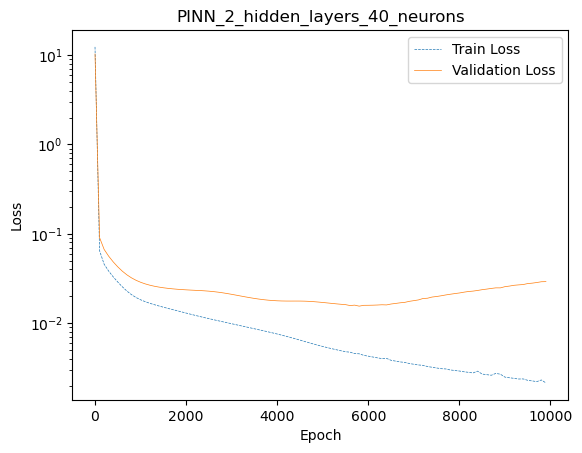

In [11]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [12]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [13]:
pdnn_trainer.train()

0 	Loss(training) = 1.0009210207126729 	Loss(validation) = 1.0347463193053947
100 	Loss(training) = 0.6403150653839207 	Loss(validation) = 0.8281112289334944
200 	Loss(training) = 0.4986316061001423 	Loss(validation) = 0.7637857387125274
300 	Loss(training) = 0.30867346172112425 	Loss(validation) = 0.7134271752027914
400 	Loss(training) = 0.1940746780109271 	Loss(validation) = 0.7111719775340904
500 	Loss(training) = 0.11436303278362588 	Loss(validation) = 0.7545992810840139
600 	Loss(training) = 0.06443202194847523 	Loss(validation) = 0.8020025766542235
700 	Loss(training) = 0.03752085967619732 	Loss(validation) = 0.8351071761712079
800 	Loss(training) = 0.02433189570607714 	Loss(validation) = 0.8514949518358177
900 	Loss(training) = 0.017204624737871717 	Loss(validation) = 0.8591794522405258
1000 	Loss(training) = 0.012768096192372907 	Loss(validation) = 0.8660389751076052
1100 	Loss(training) = 0.009777447927286485 	Loss(validation) = 0.8743155574889461
1200 	Loss(training) = 0.0076

9800 	Loss(training) = 4.4723344973617996e-06 	Loss(validation) = 0.9523418080645529
9900 	Loss(training) = 1.5036883642314193e-05 	Loss(validation) = 0.952827438678637


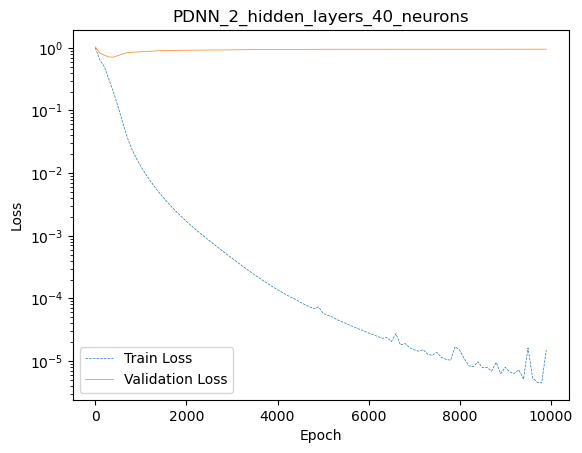

In [14]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [15]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 10.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [16]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 18.237252608801562 	Loss(validation) = 15.812025087185477
100 	Loss(training) = 0.8661878966753175 	Loss(validation) = 1.0812012515305387
200 	Loss(training) = 0.6574991603390941 	Loss(validation) = 0.8455061221783663
300 	Loss(training) = 0.6161167818924356 	Loss(validation) = 0.8057620540716389
400 	Loss(training) = 0.6018109302144125 	Loss(validation) = 0.7908825660773917
500 	Loss(training) = 0.5865025094604337 	Loss(validation) = 0.7807236821959672
600 	Loss(training) = 0.5681066193643309 	Loss(validation) = 0.7722107416521105
700 	Loss(training) = 0.5486260607030257 	Loss(validation) = 0.7646704687428612
800 	Loss(training) = 0.5290135925062893 	Loss(validation) = 0.7567983134335099
900 	Loss(training) = 0.5078695702900649 	Loss(validation) = 0.7473723701635573
1000 	Loss(training) = 0.48465307447607314 	Loss(validation) = 0.7365586

9900 	Loss(training) = 0.0024612165585048175 	Loss(validation) = 0.6583211322890595
10000 	Loss(training) = 0.0024147838632763347 	Loss(validation) = 0.658127398363225
10100 	Loss(training) = 0.002451059728780032 	Loss(validation) = 0.6575801826598131
10200 	Loss(training) = 0.0024256149142699145 	Loss(validation) = 0.6579991667610199
10300 	Loss(training) = 0.0024104836774025296 	Loss(validation) = 0.6571104936172489
10400 	Loss(training) = 0.002253464291365481 	Loss(validation) = 0.6571757119112506
10500 	Loss(training) = 0.0022107054665235814 	Loss(validation) = 0.6571186502392781
10600 	Loss(training) = 0.0021766733326817425 	Loss(validation) = 0.6570756936639424
10700 	Loss(training) = 0.002143656250248667 	Loss(validation) = 0.6570892724413762
10800 	Loss(training) = 0.0021109949600868526 	Loss(validation) = 0.657084906358867
10900 	Loss(training) = 0.00212030370078973 	Loss(validation) = 0.6572402105230579
11000 	Loss(training) = 0.0021057139037336395 	Loss(validation) = 0.65718

19600 	Loss(training) = 0.0010076282675988957 	Loss(validation) = 0.6963105913752675
19700 	Loss(training) = 0.0009946239976961952 	Loss(validation) = 0.6963401198394236
19800 	Loss(training) = 0.001212331446117321 	Loss(validation) = 0.6973973298964983
19900 	Loss(training) = 0.0010165024728919477 	Loss(validation) = 0.6974863926060604
20000 	Loss(training) = 0.0011007873973793798 	Loss(validation) = 0.6973571044381937
20100 	Loss(training) = 0.000963585645105045 	Loss(validation) = 0.697663790548498
20200 	Loss(training) = 0.0009704689608287742 	Loss(validation) = 0.6977817049019769
20300 	Loss(training) = 0.0009765400775925991 	Loss(validation) = 0.698444062156826
20400 	Loss(training) = 0.001593037717082288 	Loss(validation) = 0.7007897400472507
20500 	Loss(training) = 0.001075611113942131 	Loss(validation) = 0.6983608605135436
20600 	Loss(training) = 0.0009412430050220752 	Loss(validation) = 0.6990949368474856
20700 	Loss(training) = 0.0010932218402397568 	Loss(validation) = 0.699

29300 	Loss(training) = 0.0006584805749460514 	Loss(validation) = 0.7184578764662229
29400 	Loss(training) = 0.0006736170994687514 	Loss(validation) = 0.718124375802206
29500 	Loss(training) = 0.0006451545030496419 	Loss(validation) = 0.7186386241459057
29600 	Loss(training) = 0.0006516924202349076 	Loss(validation) = 0.7191021143055275
29700 	Loss(training) = 0.0006492383655205755 	Loss(validation) = 0.7192529749459468
29800 	Loss(training) = 0.0006376891344122711 	Loss(validation) = 0.7191561883421976
29900 	Loss(training) = 0.0006525153193987463 	Loss(validation) = 0.7193207974574317
30000 	Loss(training) = 0.0006422404789011794 	Loss(validation) = 0.7195998816753906
30100 	Loss(training) = 0.0007099251949681792 	Loss(validation) = 0.7190313415957643
30200 	Loss(training) = 0.0007300102246620505 	Loss(validation) = 0.719887707949494
30300 	Loss(training) = 0.0006890916922180111 	Loss(validation) = 0.7208126901052282
30400 	Loss(training) = 0.00065837714739816 	Loss(validation) = 0.7

39000 	Loss(training) = 0.0005059544441386986 	Loss(validation) = 0.7349692284271544
39100 	Loss(training) = 0.0004972843313733385 	Loss(validation) = 0.7350007126338534
39200 	Loss(training) = 0.0004964633712391183 	Loss(validation) = 0.7351332564345854
39300 	Loss(training) = 0.000507202949863916 	Loss(validation) = 0.7354752770715429
39400 	Loss(training) = 0.0007661377252458511 	Loss(validation) = 0.7367630190254306
39500 	Loss(training) = 0.0005031649790818316 	Loss(validation) = 0.7359227391384775
39600 	Loss(training) = 0.0004962205923548256 	Loss(validation) = 0.7357904297739211
39700 	Loss(training) = 0.0005711771066317241 	Loss(validation) = 0.736244102178169
39800 	Loss(training) = 0.0005150149723755963 	Loss(validation) = 0.7358314702660121
39900 	Loss(training) = 0.0004874172867577147 	Loss(validation) = 0.7365309513047549


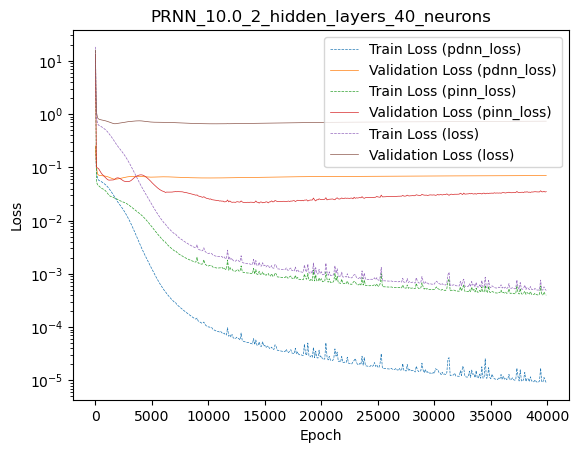

In [17]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [18]:
np.random.seed(0)

reduction_method.initialize_testing_set(100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

#### 4.6.2 PINN Error Analysis

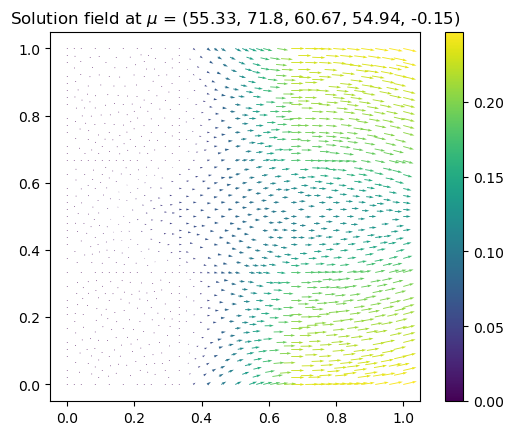

In [19]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [20]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn
)

################################# PINN N = 17 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.01178488530582687	0.011788313488187709	0.00016086903769987337
mean	0.07651055050083322	0.0764997416682782	0.0007091434982021367
max	0.36021833486772586	0.3602275352065732	0.0021554753883565895


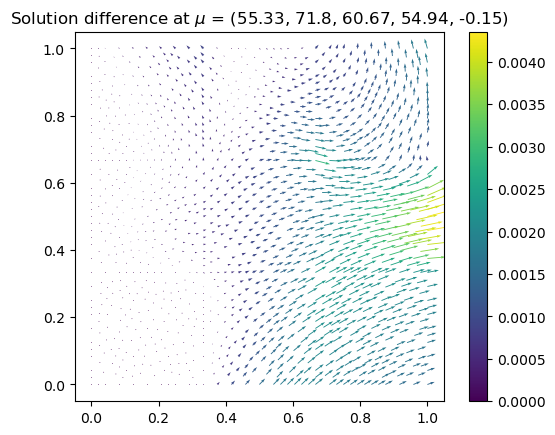

In [21]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 17 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0003090513072852393	0.0001373808603113484	0.00016086903769987337
mean	0.02635950060619201	0.02615909918287643	0.0007091434982021367
max	0.32315555358780457	0.3232077907608833	0.0021554753883565895


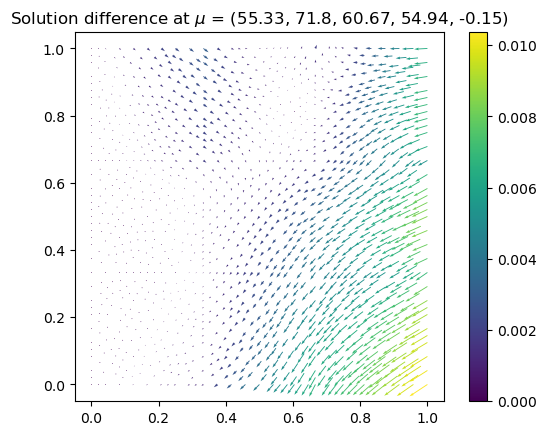

In [23]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [24]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################### PRNN_10.0 N = 17 ###############################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0007021390592880628	0.00043124322857925144	0.00016086903769987337
mean	0.012750409905117908	0.012677916007874254	0.0007091434982021367
max	0.19594274116469657	0.19605524027856644	0.0021554753883565895


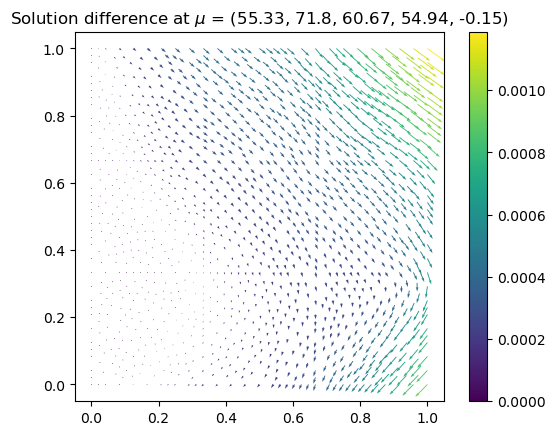

In [25]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [26]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 17 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.07651055050083322	0.0764997416682782	0.0007091434982021367
pdnn_net	0.02635950060619201	0.02615909918287643	0.0007091434982021367
prnn_net	0.012750409905117908	0.012677916007874254	0.0007091434982021367
#####################################################################################


### 4.7. Perform a speedup analysis

In [27]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=               ElasticBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N 	gmean(error_u)       	max(error_u)        	gmean(relative_error_u)	max(relative_error_u)
1 	0.20809532460690264  	0.6853502912049342  	0.399503503662445      	0.8690640094744511   
2 	0.07311568297313081  	0.5879332772819379  	0.1403682258388877     	0.6420964931497263   
3 	0.05907267209491152  	0.5659740419173758  	0.11340831187437976    	0.6181142683554095   
4 	0.04234624017361832  	0.5649192172601961  	0.08129673911823548    	0.6169622682230235   
5 	0.02757365411447827  	0.5646408365101997  	0.052936179360682546   	0.6166582417114448   
6 	0.014409413912583586 	0.2685079841140955  	0.027663338206535402   	0.2932442194451369   
7 	0.010451751268016554 	0.2082678598678857  	0.020065377532477762   	0.22745448782080077  
8 	0.007175592187021258 	0.11282835401157533 	0.013775774275482067   	0.12322263977574999  
9 	0.006269859104287392 	0.1129462561799406  	0.01203693876527203    	0.12335140365384185 

###################################### 74 ######################################
###################################### 75 ######################################
###################################### 76 ######################################
###################################### 77 ######################################
###################################### 78 ######################################
###################################### 79 ######################################
###################################### 80 ######################################
###################################### 81 ######################################
###################################### 82 ######################################
###################################### 83 ######################################
###################################### 84 ######################################
###################################### 85 ######################################
############################